In [12]:
import numpy as np
import ot
from SVM_Experiments import SVMExperiment
from Data.Dataset import LatentFMRIDataset
import matplotlib.pylab as pl
import ot.plot
from sklearn.utils import shuffle

In [13]:
nyu_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_all'
um1_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/UM_1_all'
merged_set_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_UM1_merged'

In [14]:
train_data = LatentFMRIDataset(data_dir=nyu_dataset_directory).get_all_items()
test_data = LatentFMRIDataset(data_dir=um1_dataset_directory).get_all_items()

In [15]:
number_of_datapoints = -1

In [16]:
X_train = train_data['X']
y_train = train_data['y']
X_test = test_data['X']
y_test = test_data['y']
X_test, y_test = shuffle(X_test, y_test, random_state=41)
X_train = X_train.reshape((X_train.shape[0], -1))[0:number_of_datapoints]
X_test = X_test.reshape((X_test.shape[0], -1))[0:number_of_datapoints]
y_train = y_train[0:number_of_datapoints]
y_test = y_test[0:number_of_datapoints]

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2, 1152), (2,), (2, 1152), (2,))

In [18]:
Xs = X_test
Xt = X_train
ys = y_test
yt = y_train

In [19]:
# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs, ys=ys, Xt=Xt, yt=yt)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, ys=ys, Xt=Xt, yt=yt)

# Sinkhorn Transport with Group lasso regularization
ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt, yt=yt)

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=Xs)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)

/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


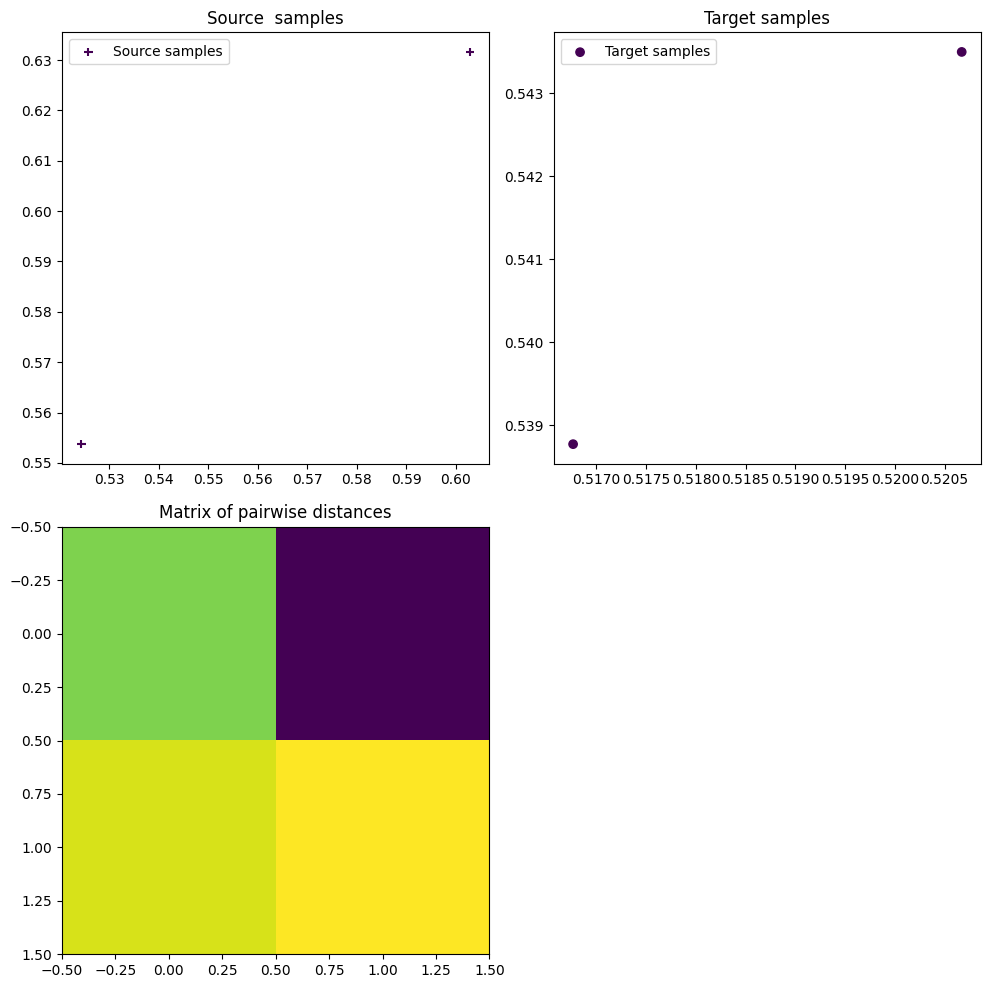

In [20]:
M = ot.dist(Xs, Xt, metric='sqeuclidean')

pl.figure(1, figsize=(10, 10))
pl.subplot(2, 2, 1)
pl.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+', label='Source samples')
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(2, 2, 2)
pl.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label='Target samples')
pl.legend(loc=0)
pl.title('Target samples')

pl.subplot(2, 2, 3)
pl.imshow(M, interpolation='nearest')
pl.title('Matrix of pairwise distances')
pl.tight_layout()

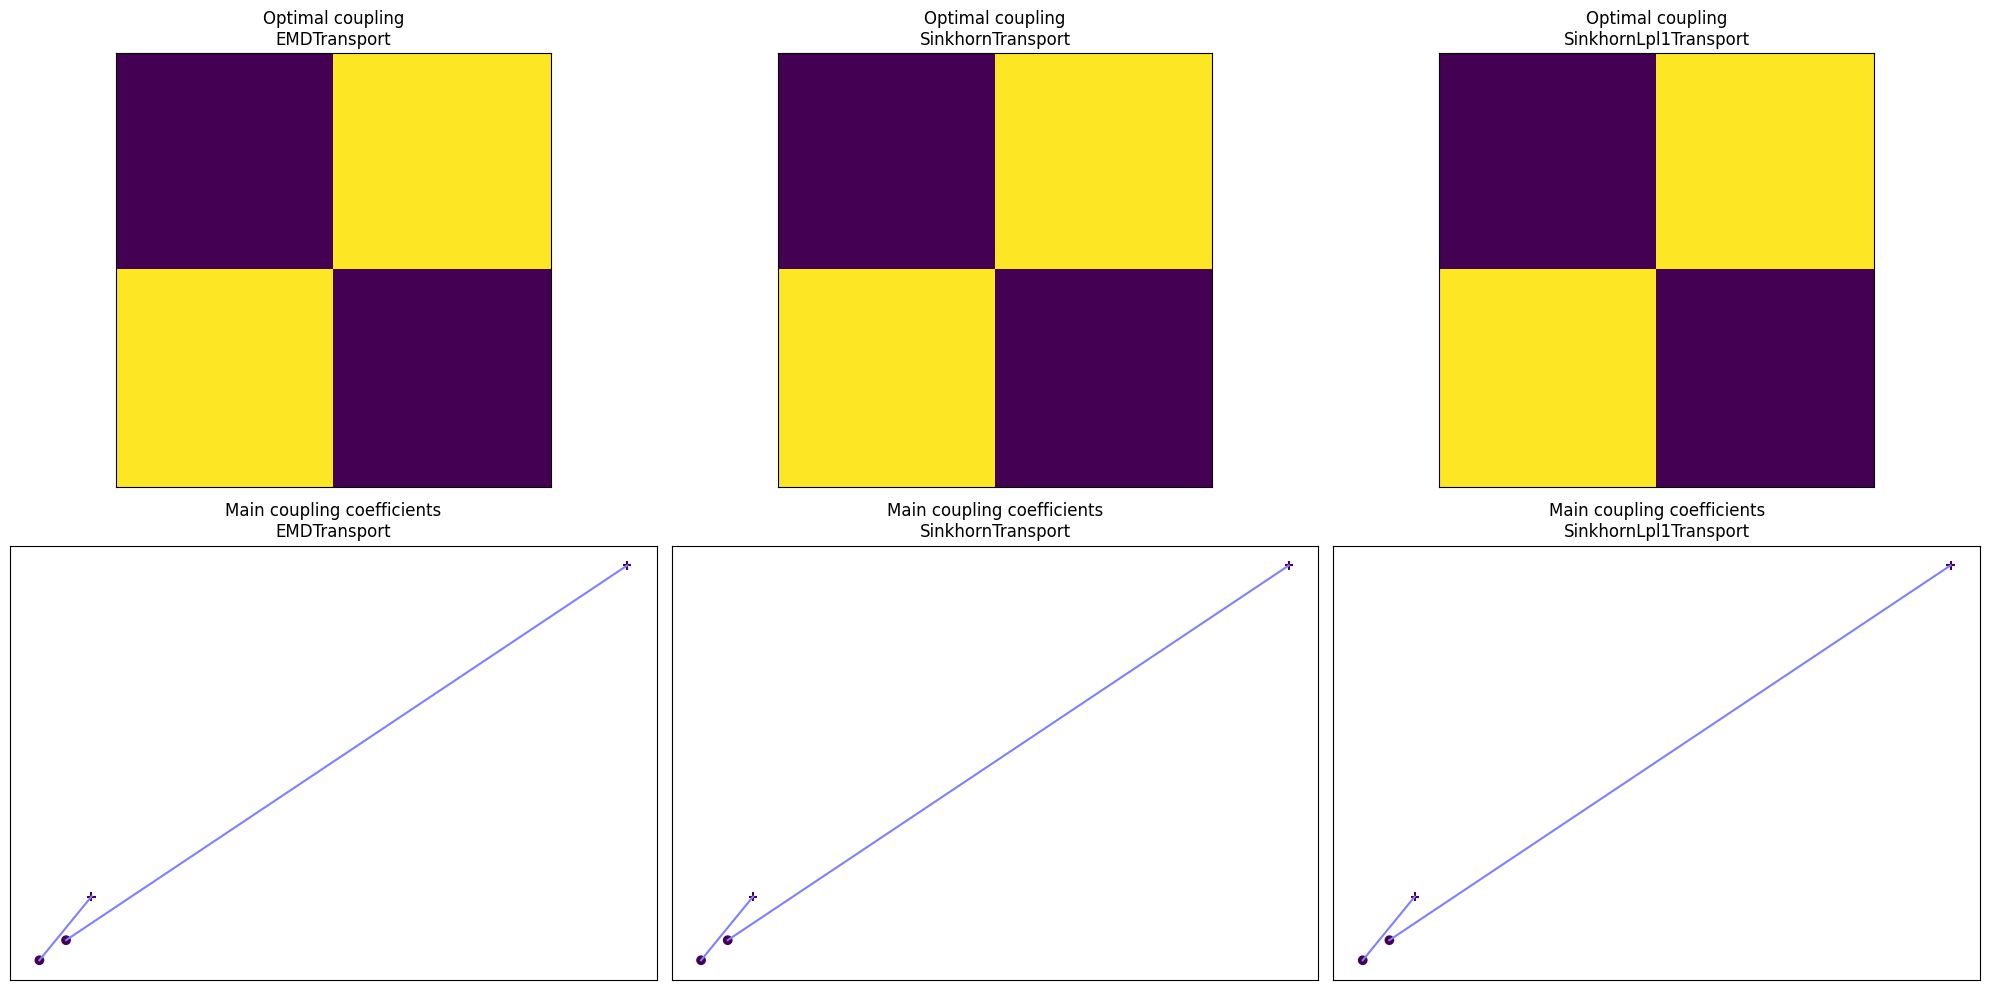

In [21]:
pl.figure(2, figsize=(20, 10))

pl.subplot(2, 3, 1)
pl.imshow(ot_emd.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nEMDTransport')

pl.subplot(2, 3, 2)
pl.imshow(ot_sinkhorn.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornTransport')

pl.subplot(2, 3, 3)
pl.imshow(ot_lpl1.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornLpl1Transport')

pl.subplot(2, 3, 4)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_emd.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nEMDTransport')

pl.subplot(2, 3, 5)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_sinkhorn.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nSinkhornTransport')

pl.subplot(2, 3, 6)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_lpl1.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nSinkhornLpl1Transport')
pl.tight_layout()

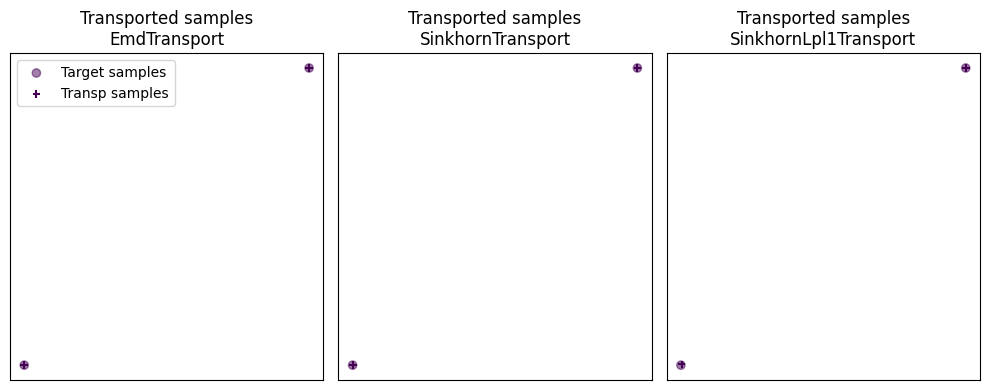

In [22]:
# display transported samples
pl.figure(4, figsize=(10, 4))
pl.subplot(1, 3, 1)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nEmdTransport')
pl.legend(loc=0)
pl.xticks([])
pl.yticks([])

pl.subplot(1, 3, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nSinkhornTransport')
pl.xticks([])
pl.yticks([])

pl.subplot(1, 3, 3)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nSinkhornLpl1Transport')
pl.xticks([])
pl.yticks([])

pl.tight_layout()
pl.show()